In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".80"

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from jax_tqdm import scan_tqdm

import spyx

### SHD Dataloading

In [2]:

from collections import namedtuple

import tonic
from tonic import datasets, transforms
from torch.utils.data import DataLoader

State = namedtuple("State", "obs labels")



In [3]:
class _SHD2Raster():
    """ 
    Tool for rastering SHD samples into frames. Packs bits along the temporal axis for memory efficiency. This means
        that the used will have to apply jnp.unpackbits(events, axis=<time axis>) prior to feeding the data to the network.
    """

    def __init__(self, encoding_dim, sample_T = 100):
        self.encoding_dim = encoding_dim
        self.sample_T = sample_T
        
    def __call__(self, events):
        # tensor has dimensions (time_steps, encoding_dim)
        tensor = np.zeros((events["t"].max()+1, self.encoding_dim), dtype=int)
        np.add.at(tensor, (events["t"], events["x"]), 1)
        #return tensor[:self.sample_T,:]
        tensor = tensor[:self.sample_T,:]
        tensor = np.minimum(tensor, 1)
        tensor = np.packbits(tensor, axis=0)
        return tensor

In [4]:
sample_T = 64
shd_timestep = 1e-6
shd_channels = 700
net_channels = 128
net_dt = 1/sample_T
batch_size = 256

obs_shape = tuple([net_channels,])
act_shape = tuple([20,])

transform = transforms.Compose([
    transforms.Downsample(
        time_factor=shd_timestep / net_dt,
        spatial_factor=net_channels / shd_channels
    ),
    _SHD2Raster(net_channels, sample_T=sample_T)
])

train_dataset = datasets.SHD("./data", train=True, transform=transform)
test_dataset = datasets.SHD("./data", train=False, transform=transform)



In [5]:
train_dl = iter(DataLoader(train_dataset, batch_size=len(train_dataset),
                          collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False))
        
x_train, y_train = next(train_dl)

In [6]:
test_dl = iter(DataLoader(test_dataset, batch_size=len(test_dataset),
                          collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False))
        
x_test, y_test = next(test_dl)

In [7]:
print(type(x_train))
print(x_train.shape)

<class 'torch.Tensor'>
torch.Size([8156, 8, 128])


In [8]:
x_train = jnp.array(x_train, dtype=jnp.uint8)
y_train = jnp.array(y_train, dtype=jnp.uint8)

x_test = jnp.array(x_test, dtype=jnp.uint8)
y_test = jnp.array(y_test, dtype=jnp.uint8)

In [9]:
def shuffle(dataset, shuffle_rng):
    x, y = dataset

    cutoff = y.shape[0] % batch_size

    obs = jax.random.permutation(shuffle_rng, x, axis=0)[:-cutoff]
    labels = jax.random.permutation(shuffle_rng, y, axis=0)[:-cutoff]

    obs = jnp.reshape(obs, (-1, batch_size) + obs.shape[1:])
    labels = jnp.reshape(labels, (-1, batch_size)) # should make batch size a global

    return State(obs=obs, labels=labels)

### Spyx SHD

In [41]:
def shd_snn(x): # batch, time, channels
        
    k1, k2, k3 = jax.random.split(hk.next_rng_key(), 3)
    x = hk.BatchApply(hk.Linear(64, with_bias=False))(x)
    x, V = spyx.experimental.SPSN((64,), k=12)(k1, x)
    x = hk.BatchApply(hk.Linear(64, with_bias=False))(x)
    x, V = spyx.experimental.SPSN((64,), k=12)(k2, x)
    x = hk.BatchApply(hk.Linear(20, with_bias=False))(x)
    spikes, V = spyx.experimental.SPSN((), k=12)(k3, x)
    return spikes, V

In [42]:
key = jax.random.PRNGKey(0)
key1, key2 = jax.random.split(key)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
sample_x, sample_y = shuffle((x_train,y_train),key)
SNN = hk.transform(shd_snn)
params = SNN.init(rng=key1, x=jnp.float32(jnp.unpackbits(sample_x[0], axis=1)))

In [19]:
def gd(SNN, params, dataset, epochs=300):
        
    opt = optax.adam(learning_rate=5e-4)
    
    # create and initialize the optimizer
    opt_state = opt.init(params)
    grad_params = params
        
    # define and compile our eval function that computes the loss for our SNN
    @jax.jit
    def net_eval(weights, events, targets, apply_key):
        readout = SNN.apply(weights, apply_key, events)
        spikes, V = readout
        return spyx.fn.integral_crossentropy(V, targets) # smoothing needs to be more explicit in docs...
        
    # Use JAX to create a function that calculates the loss and the gradient!
    surrogate_grad = jax.value_and_grad(net_eval) 
        
    rng = jax.random.PRNGKey(0)        
    
    # compile the meat of our training loop for speed
    @jax.jit
    def train_step(state, data):
        grad_params, opt_state, batch_key = state
        batch_key, new_batch_key = jax.random.split(batch_key)
        events, targets = data # fix this
        events = jnp.unpackbits(events, axis=1) # decompress temporal axis
        # compute loss and gradient                    # need better augment rng
        loss, grads = surrogate_grad(grad_params, events, targets, new_batch_key)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state, batch_key]
        return new_state, loss
    
    
    # Here's the start of our training loop!
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state, rng = epoch_state

        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        net_key = jax.random.fold_in(shuffle_rng, epoch_num)

        train_data = shuffle(dataset, shuffle_rng)
        
        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# func
            [curr_params, curr_opt_state, net_key],# init
            train_data,# xs
            train_data.obs.shape[0]# len
        )
                    
        return end_state, jnp.mean(train_loss)
    # end epoch
    
    # epoch loop
    final_state, metrics = jax.lax.scan(
        epoch,
        [grad_params, opt_state, rng], # metric arrays
        jnp.arange(epochs), # 
        epochs # len of loop
    )
    
    final_params, _, _ = final_state
                
    # return our final, optimized network.       
    return final_params, metrics

In [20]:
def test_gd(SNN, params, dataset):

    @jax.jit
    def test_step(test_state, data):
        params, batch_rng = test_state
        inference_rng, next_rng = jax.random.split(batch_rng)
        events, targets = data
        events = jnp.unpackbits(events, axis=1)
        readout = SNN.apply(params, inference_rng, events)
        traces, V = readout
        acc, pred = spyx.fn.integral_accuracy(V, targets)
        loss = spyx.fn.integral_crossentropy(V, targets)
        return [params, next_rng], [acc, loss, pred, targets]
    
    test_data = shuffle(dataset, jax.random.PRNGKey(0))
    rng_test = jax.random.PRNGKey(1)
    
    _, test_metrics = jax.lax.scan(
            test_step,# func
            [params, rng_test],# init
            test_data,# xs
            test_data.obs.shape[0]# len
    )
    
    acc = jnp.mean(test_metrics[0])
    loss = jnp.mean(test_metrics[1])
    preds = jnp.array(test_metrics[2]).flatten()
    tgts = jnp.array(test_metrics[3]).flatten()
    return acc, loss, preds, tgts

In [43]:
grad_params, metrics = gd(SNN, params, (x_train,y_train), epochs=300)


  0%|          | 0/300 [00:00<?, ?it/s]

In [44]:
metrics

Array([2.9956043, 2.9934208, 2.98255  , 2.957374 , 2.9138606, 2.855092 ,
       2.785295 , 2.7272317, 2.6851356, 2.6476836, 2.605815 , 2.5535028,
       2.5022476, 2.4553697, 2.4211712, 2.394369 , 2.3722808, 2.3504639,
       2.325668 , 2.318754 , 2.3070316, 2.2884145, 2.270905 , 2.2603269,
       2.248262 , 2.2349942, 2.2173157, 2.2085726, 2.197127 , 2.1876035,
       2.1733255, 2.15996  , 2.1576474, 2.1451411, 2.1372874, 2.132701 ,
       2.11767  , 2.1075215, 2.1051881, 2.0995646, 2.0881402, 2.0841293,
       2.0770936, 2.0695984, 2.0629935, 2.0589275, 2.051084 , 2.0387058,
       2.038746 , 2.0283213, 2.0209675, 2.0162504, 2.009159 , 2.0057366,
       2.0007846, 1.9970376, 1.988    , 1.9855984, 1.9777839, 1.9737867,
       1.9708807, 1.9652989, 1.955189 , 1.9531864, 1.9484136, 1.9465481,
       1.9345324, 1.9319713, 1.9273002, 1.9265085, 1.9201834, 1.91493  ,
       1.912744 , 1.9074663, 1.9026384, 1.9004493, 1.8955985, 1.8955228,
       1.8853617, 1.8877478, 1.8854117, 1.8743522, 

In [45]:
acc, loss, preds, tgts = test_gd(SNN, grad_params, (x_test,y_test))
print("Accuracy:", acc, "Loss:", loss)

Accuracy: 0.72216797 Loss: 2.0229526


In [30]:
grad_params = spyx.nir.reorder_layers(params, grad_params)

In [32]:
grad_params["SPSN_2"]

{'beta': Array(-0.00500731, dtype=float32)}

In [19]:
params["linear_2"]

{'w': Array([[-0.04298574,  0.21619943,  0.10477108, ..., -0.10754719,
         -0.04965809, -0.03431261],
        [-0.01796218,  0.05607246, -0.04709149, ...,  0.1947771 ,
         -0.10933241,  0.00303009],
        [ 0.0482173 , -0.03384301, -0.12288244, ...,  0.10351518,
          0.11186872,  0.08066373],
        ...,
        [ 0.19588879, -0.05644256, -0.07959975, ..., -0.08587369,
         -0.18150201, -0.12443399],
        [ 0.00163213,  0.07380239, -0.06773511, ..., -0.0573804 ,
          0.03488021, -0.21297358],
        [ 0.17212132,  0.09933139, -0.08786933, ...,  0.04749663,
         -0.22334315,  0.16538994]], dtype=float32)}

In [33]:
s1, v1 = SNN.apply(params, jax.random.PRNGKey(42), jnp.unpackbits(sample_x[0], 1))
s2, v2 = SNN.apply(grad_params, jax.random.PRNGKey(42), jnp.unpackbits(sample_x[0], 1))


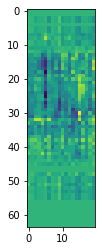

In [34]:
import matplotlib.pyplot as plt

plt.imshow(v1[0]-v2[0])

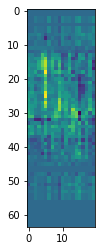

In [35]:
plt.imshow(v2[0])

### Use NIR to save our network and then load it up later, in any framework of our choosing!

In [17]:
export_params = spyx.nir.reorder_layers(params, grad_params)
G = spyx.nir.to_nir(export_params, obs_shape, act_shape, 1)
#nir.write("./spyx_shd.nir", G)